In [1]:
import sys, os
try:
    from google.colab import drive, userdata
    IS_COLAB = True
except ImportError:
    IS_COLAB = False

REPO_NAME = 'MistakeDetection'

if IS_COLAB:
    print("☁️ Colab rilevato.")
    if not os.path.exists('/content/drive'): drive.mount('/content/drive')

    GITHUB_USER = 'MarcoPernoVDP'
    try:
        TOKEN = userdata.get('GITHUB_TOKEN')
        REPO_URL = f'https://{TOKEN}@github.com/{GITHUB_USER}/{REPO_NAME}.git'
    except:
        REPO_URL = f'https://github.com/{GITHUB_USER}/{REPO_NAME}.git'

    ROOT_DIR = f'/content/{REPO_NAME}'
    if not os.path.exists(ROOT_DIR):
        !git clone {REPO_URL}
    else:
        %cd {ROOT_DIR}
        !git pull
        %cd /content


else:
    print("Ambiente locale rilevato.")
    ROOT_DIR = os.getcwd()
    while not os.path.exists(os.path.join(ROOT_DIR, '.gitignore')) and ROOT_DIR != os.path.dirname(ROOT_DIR):
        ROOT_DIR = os.path.dirname(ROOT_DIR)

if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)


Ambiente locale rilevato.


In [2]:
# Verifica ambiente
print(f"📍 Working directory: {ROOT_DIR}")
print(f"🐍 Python environment: {'Colab' if IS_COLAB else 'Local'}")

📍 Working directory: c:\Users\enric\Desktop\MistakeDetection
🐍 Python environment: Local


# Task 2 - Subtask 3: Hungarian Matching

Matching tra video step embeddings e task graph text embeddings usando l'algoritmo Ungherese.

## 1. Installazione Dipendenze

In [3]:
if IS_COLAB:
    !pip install scipy torch_geometric matplotlib seaborn -q

import numpy as np
import json
import zipfile
from pathlib import Path
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerie caricate")

✅ Librerie caricate


## 2. Configurazione Path

**Modifica questi path secondo la tua struttura:**

In [4]:
if IS_COLAB:
    # ========== CONFIGURA QUESTI PATH PER COLAB ==========
    VIDEO_FEATURES_PATH = "/content/drive/MyDrive/MistakeDetection/hiero_all_video_steps.npz"
    RECIPE_EMBEDDINGS_DIR = "/content/drive/MyDrive/MistakeDetection/recipe_embeddings"
    ANNOTATION_JSON_PATH = "/content/drive/MyDrive/MistakeDetection/annotation_json/complete_step_annotations.json"
    OUTPUT_DIR = "/content/drive/MyDrive/MistakeDetection/hungarian_results"
    # ====================================================
else:
    # ========== CONFIGURA QUESTI PATH PER LOCALE ==========
    VIDEO_FEATURES_PATH = str(Path(ROOT_DIR) / "data" / "hiero_all_video_steps.npz")
    RECIPE_EMBEDDINGS_DIR = str(Path(ROOT_DIR) / "data" / "recipe_embeddings")
    ANNOTATION_JSON_PATH = str(Path(ROOT_DIR) / "data" / "annotation_json" / "complete_step_annotations.json")
    OUTPUT_DIR = str(Path(ROOT_DIR) / "output" / "hungarian_results")
    # ====================================================

# Crea cartella output
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print("📁 Configurazione:")
print(f"  Video features: {VIDEO_FEATURES_PATH}")
print(f"  Recipe embeddings dir: {RECIPE_EMBEDDINGS_DIR}")
print(f"  Annotation: {ANNOTATION_JSON_PATH}")
print(f"  Output directory: {OUTPUT_DIR}")

📁 Configurazione:
  Video features: c:\Users\enric\Desktop\MistakeDetection\data\hiero_all_video_steps.npz
  Recipe embeddings dir: c:\Users\enric\Desktop\MistakeDetection\data\recipe_embeddings
  Annotation: c:\Users\enric\Desktop\MistakeDetection\data\annotation_json\complete_step_annotations.json
  Output directory: c:\Users\enric\Desktop\MistakeDetection\output\hungarian_results


In [5]:
import json
import re
import torch

print("📦 Caricamento Video Features...")

# 1. Carica video features (NPZ con 8 step x 768 features per ogni video)
video_features = np.load(VIDEO_FEATURES_PATH, allow_pickle=True)
print(f"✅ Video features caricate: {len(video_features.keys())} video")
print(f"   Esempio shape: {video_features[list(video_features.keys())[0]].shape}")

# 2. Carica annotazioni complete
with open(ANNOTATION_JSON_PATH, 'r') as f:
    annotations = json.load(f)
print(f"✅ Annotazioni caricate: {len(annotations)} video annotati")

# 3. Funzione per normalizzare nomi ricette
def normalizza_nome_ricetta(nome_ricetta):
    """Normalizza il nome della ricetta per matchare i nomi file .pt"""
    return re.sub(r'[^a-zA-Z0-9]', '', nome_ricetta).lower()

# 4. Crea mappa video_id -> activity_name normalizzato
video_to_recipe = {}
for video_id, ann_data in annotations.items():
    if 'activity_name' in ann_data:
        activity_name = ann_data['activity_name']
        normalized = normalizza_nome_ricetta(activity_name)
        video_to_recipe[video_id] = normalized

print(f"✅ Mappatura video->ricetta creata: {len(video_to_recipe)} video")
print(f"   Esempio: video '1_7' -> ricetta '{video_to_recipe.get('1_7', 'N/A')}'")

📦 Caricamento Video Features...
✅ Video features caricate: 384 video
   Esempio shape: (8, 768)
✅ Annotazioni caricate: 384 video annotati
✅ Mappatura video->ricetta creata: 384 video
   Esempio: video '1_7' -> ricetta 'microwaveeggsandwich'


In [6]:
import torch
from pathlib import Path

print("📦 Caricamento Recipe Embeddings...")

# Carica tutti i recipe embeddings dalla cartella
recipe_embeddings = {}
recipe_emb_dir = Path(RECIPE_EMBEDDINGS_DIR)

for pt_file in recipe_emb_dir.glob("*.pt"):
    recipe_name = pt_file.stem  # Nome file senza estensione
    data = torch.load(pt_file)
    
    # I file .pt contengono un dict con 'embeddings' (N_steps x 768) e 'metadata'
    if isinstance(data, dict) and 'embeddings' in data:
        recipe_embeddings[recipe_name] = data['embeddings']  # Tensor shape: [N_steps, 768]
    else:
        print(f"⚠️ Formato inaspettato per {pt_file.name}")

print(f"✅ Recipe embeddings caricate: {len(recipe_embeddings)} ricette")
print(f"   Esempio: 'microwaveeggsandwich' -> shape {recipe_embeddings.get('microwaveeggsandwich', torch.tensor([])).shape}")

# Mostra tutte le ricette disponibili
print(f"\n📋 Ricette disponibili:")
for i, recipe_name in enumerate(sorted(recipe_embeddings.keys()), 1):
    n_steps = recipe_embeddings[recipe_name].shape[0]
    print(f"   {i:2d}. {recipe_name:<30} ({n_steps} steps)")

📦 Caricamento Recipe Embeddings...
✅ Recipe embeddings caricate: 24 ricette
   Esempio: 'microwaveeggsandwich' -> shape torch.Size([12, 768])

📋 Ricette disponibili:
    1. blenderbananapancakes          (14 steps)
    2. breakfastburritos              (11 steps)
    3. broccolistirfry                (25 steps)
    4. buttercorncup                  (12 steps)
    5. capresebruschetta              (11 steps)
    6. cheesepimiento                 (11 steps)
    7. coffee                         (16 steps)
    8. cucumberraita                  (11 steps)
    9. dressedupmeatballs             (16 steps)
   10. herbomeletwithfriedtomatoes    (15 steps)
   11. microwaveeggsandwich           (12 steps)
   12. microwavefrenchtoast           (11 steps)
   13. microwavemugpizza              (14 steps)
   14. mugcake                        (20 steps)
   15. panfriedtofu                   (19 steps)
   16. pinwheels                      (19 steps)
   17. ramen                          (15 steps)
 

In [7]:
from scipy.optimize import linear_sum_assignment
import numpy as np
import torch

def cosine_similarity_matrix(video_steps, recipe_steps):
    """
    Calcola la matrice di similarità coseno tra video steps e recipe steps.
    
    Args:
        video_steps: numpy array shape [8, 768] - embeddings video
        recipe_steps: torch tensor shape [N, 768] - embeddings ricetta
    
    Returns:
        numpy array shape [8, N] - matrice di similarità
    """
    # Converti a numpy se necessario
    if isinstance(recipe_steps, torch.Tensor):
        recipe_steps = recipe_steps.numpy()
    
    # Normalizza i vettori
    video_norm = video_steps / (np.linalg.norm(video_steps, axis=1, keepdims=True) + 1e-8)
    recipe_norm = recipe_steps / (np.linalg.norm(recipe_steps, axis=1, keepdims=True) + 1e-8)
    
    # Calcola similarità coseno (matrice 8 x N)
    similarity = np.dot(video_norm, recipe_norm.T)
    
    return similarity


def hungarian_matching(video_steps, recipe_steps):
    """
    Esegue il matching ottimale tra video steps e recipe steps usando l'algoritmo ungherese.
    
    Args:
        video_steps: numpy array shape [8, 768]
        recipe_steps: torch tensor shape [N, 768]
    
    Returns:
        tuple: (row_indices, col_indices, cost_matrix, total_cost)
            - row_indices: indici dei video steps matchati
            - col_indices: indici dei recipe steps matchati
            - cost_matrix: matrice dei costi (distanze)
            - total_cost: costo totale del matching
    """
    # Calcola matrice di similarità
    similarity = cosine_similarity_matrix(video_steps, recipe_steps)
    
    # Converti similarità in costi (distanza = 1 - similarità)
    cost_matrix = 1 - similarity
    
    # Se le dimensioni sono diverse, creiamo una matrice quadrata con padding
    n_video = video_steps.shape[0]  # 8
    n_recipe = recipe_steps.shape[0] if isinstance(recipe_steps, np.ndarray) else recipe_steps.shape[0]
    
    if n_video != n_recipe:
        # Crea matrice quadrata
        max_dim = max(n_video, n_recipe)
        padded_cost = np.ones((max_dim, max_dim)) * 10  # Alto costo per celle dummy
        padded_cost[:n_video, :n_recipe] = cost_matrix
        cost_matrix_for_hungarian = padded_cost
    else:
        cost_matrix_for_hungarian = cost_matrix
    
    # Applica algoritmo ungherese
    row_ind, col_ind = linear_sum_assignment(cost_matrix_for_hungarian)
    
    # Filtra solo i match validi (non dummy)
    valid_mask = (row_ind < n_video) & (col_ind < n_recipe)
    row_ind = row_ind[valid_mask]
    col_ind = col_ind[valid_mask]
    
    # Calcola costo totale
    total_cost = cost_matrix[row_ind, col_ind].sum()
    
    return row_ind, col_ind, cost_matrix, total_cost


print("✅ Funzioni di matching implementate:")
print("   - cosine_similarity_matrix()")
print("   - hungarian_matching()")

✅ Funzioni di matching implementate:
   - cosine_similarity_matrix()
   - hungarian_matching()


In [8]:
print("🔄 Esecuzione Hungarian Matching su tutti i video...")
print("="*70)

# Dizionario per salvare i risultati
matching_results = {}
statistics = {
    'total_videos': 0,
    'successful_matches': 0,
    'failed_matches': 0,
    'missing_recipe_embeddings': 0
}

# Converti le chiavi in lista per iterazione
all_video_ids = list(video_features.keys())
total_videos = len(all_video_ids)

print(f"📊 Totale video da processare: {total_videos}")
print()

# Itera su TUTTI i video
for i, video_id in enumerate(all_video_ids, 1):
    statistics['total_videos'] += 1
    
    # Progress bar
    if i % 50 == 0 or i == total_videos:
        progress = (i / total_videos) * 100
        print(f"Progress: {i}/{total_videos} ({progress:.1f}%)")
    
    # Ottieni video embeddings (8 x 768)
    video_emb = video_features[video_id]
    
    # Estrai video_id base (rimuovi suffisso _360p_224.mp4_1s_1s)
    video_id_base = video_id.replace('_360p_224.mp4_1s_1s', '')
    
    # Trova il nome della ricetta corrispondente
    recipe_name = video_to_recipe.get(video_id_base)
    
    if recipe_name is None:
        statistics['failed_matches'] += 1
        continue
    
    # Ottieni recipe embeddings
    recipe_emb = recipe_embeddings.get(recipe_name)
    
    if recipe_emb is None:
        statistics['missing_recipe_embeddings'] += 1
        continue
    
    # Esegui Hungarian matching
    try:
        row_ind, col_ind, cost_matrix, total_cost = hungarian_matching(video_emb, recipe_emb)
        
        # Calcola accuracy media
        similarity_matrix = 1 - cost_matrix
        avg_similarity = similarity_matrix[row_ind, col_ind].mean()
        
        # Salva risultati
        matching_results[video_id] = {
            'recipe_name': recipe_name,
            'video_steps': row_ind.tolist(),
            'recipe_steps': col_ind.tolist(),
            'total_cost': float(total_cost),
            'avg_similarity': float(avg_similarity),
            'n_video_steps': len(video_emb),
            'n_recipe_steps': len(recipe_emb),
            'matches': list(zip(row_ind.tolist(), col_ind.tolist()))
        }
        
        statistics['successful_matches'] += 1
        
    except Exception as e:
        statistics['failed_matches'] += 1

print("\n" + "="*70)
print("📊 STATISTICHE MATCHING:")
print(f"   Total videos processati: {statistics['total_videos']}")
print(f"   ✅ Successful matches: {statistics['successful_matches']}")
print(f"   ⚠️ Failed matches: {statistics['failed_matches']}")
print(f"   ⚠️ Missing recipe embeddings: {statistics['missing_recipe_embeddings']}")
print("="*70)

🔄 Esecuzione Hungarian Matching su tutti i video...
📊 Totale video da processare: 384

Progress: 50/384 (13.0%)
Progress: 100/384 (26.0%)
Progress: 150/384 (39.1%)
Progress: 200/384 (52.1%)
Progress: 250/384 (65.1%)
Progress: 300/384 (78.1%)
Progress: 350/384 (91.1%)
Progress: 384/384 (100.0%)

📊 STATISTICHE MATCHING:
   Total videos processati: 384
   ✅ Successful matches: 384
   ⚠️ Failed matches: 0
   ⚠️ Missing recipe embeddings: 0


In [9]:
# Analizza un video specifico in dettaglio (esempio)
if matching_results:
    test_video_id = list(matching_results.keys())[0]
    result = matching_results[test_video_id]
    
    print(f"🔍 ESEMPIO - Video: {test_video_id}")
    print("="*70)
    print(f"📝 Ricetta: {result['recipe_name']}")
    print(f"📊 Similarità media: {result['avg_similarity']:.4f}")
    print(f"💰 Costo totale: {result['total_cost']:.4f}")
    print(f"📹 Video steps: {result['n_video_steps']}")
    print(f"📋 Recipe steps: {result['n_recipe_steps']}")
    print(f"🔗 Matches: {len(result['matches'])} video-recipe step pairs")
    print("="*70)

🔍 ESEMPIO - Video: 16_39_360p_224.mp4_1s_1s
📝 Ricetta: scrambledeggs
📊 Similarità media: 0.2433
💰 Costo totale: 6.0539
📹 Video steps: 8
📋 Recipe steps: 23
🔗 Matches: 8 video-recipe step pairs


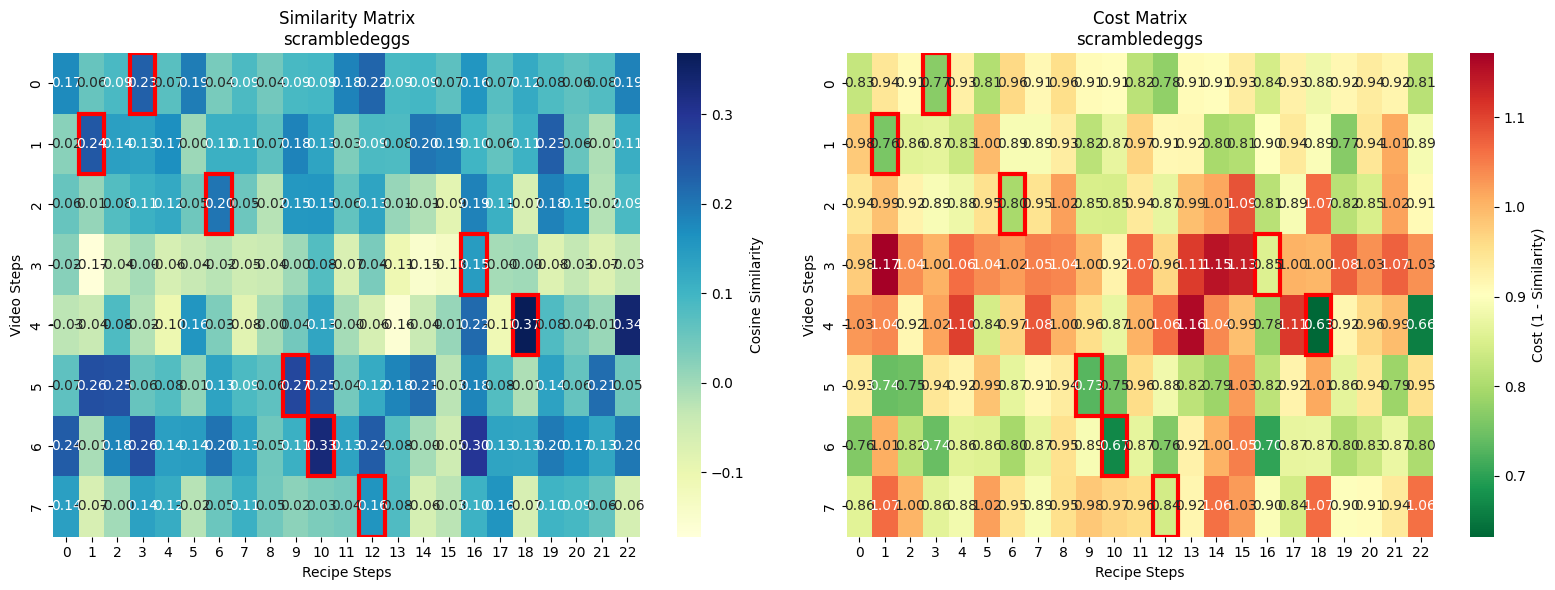

✅ Visualizzazione salvata in: c:\Users\enric\Desktop\MistakeDetection\output\hungarian_results


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizza matrice di costo per un video specifico
if matching_results:
    test_video_id = list(matching_results.keys())[0]
    result = matching_results[test_video_id]
    
    # Ricalcola la matrice di costo per visualizzazione
    video_emb = video_features[test_video_id]
    recipe_emb = recipe_embeddings[result['recipe_name']]
    
    _, _, cost_matrix, _ = hungarian_matching(video_emb, recipe_emb)
    similarity_matrix = 1 - cost_matrix
    
    # Crea figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Matrice di similarità
    sns.heatmap(similarity_matrix, annot=True, fmt='.2f', cmap='YlGnBu', 
                ax=ax1, cbar_kws={'label': 'Cosine Similarity'})
    ax1.set_xlabel('Recipe Steps')
    ax1.set_ylabel('Video Steps')
    ax1.set_title(f'Similarity Matrix\n{result["recipe_name"]}')
    
    # Evidenzia i match selezionati dall'algoritmo ungherese
    for video_idx, recipe_idx in result['matches']:
        ax1.add_patch(plt.Rectangle((recipe_idx, video_idx), 1, 1, 
                                     fill=False, edgecolor='red', lw=3))
    
    # Plot 2: Matrice di costo
    sns.heatmap(cost_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r', 
                ax=ax2, cbar_kws={'label': 'Cost (1 - Similarity)'})
    ax2.set_xlabel('Recipe Steps')
    ax2.set_ylabel('Video Steps')
    ax2.set_title(f'Cost Matrix\n{result["recipe_name"]}')
    
    # Evidenzia i match selezionati
    for video_idx, recipe_idx in result['matches']:
        ax2.add_patch(plt.Rectangle((recipe_idx, video_idx), 1, 1, 
                                     fill=False, edgecolor='red', lw=3))
    
    plt.tight_layout()
    plt.savefig(Path(OUTPUT_DIR) / f'hungarian_matching_{test_video_id}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Visualizzazione salvata in: {OUTPUT_DIR}")
else:
    print("⚠️ Nessun risultato di matching disponibile da visualizzare")

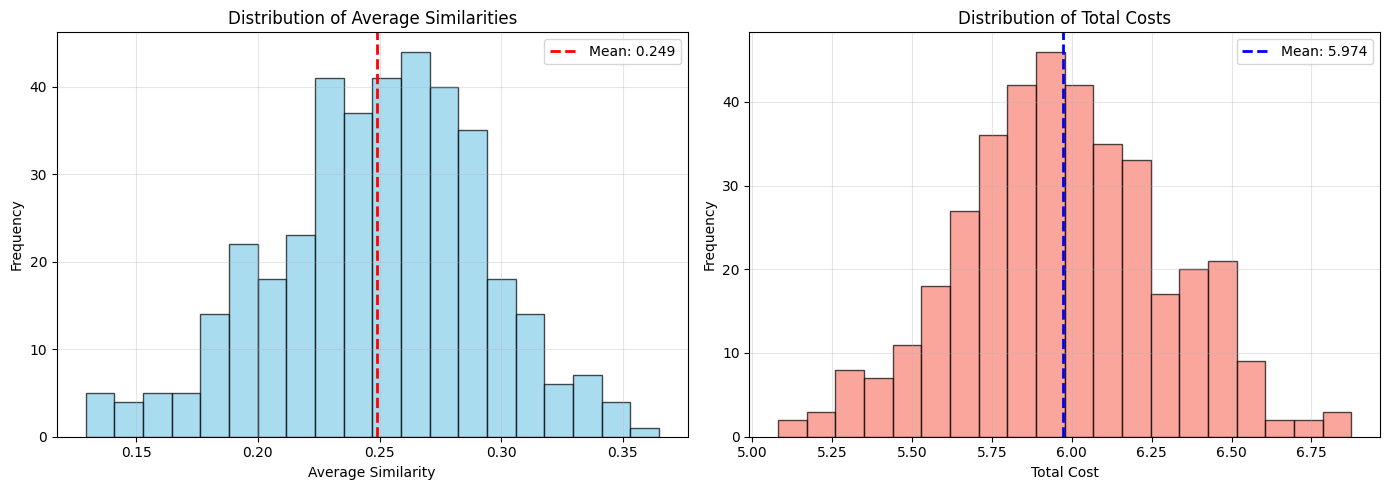

📊 STATISTICHE GLOBALI:
   Similarità media: 0.2490 ± 0.0431
   Similarità min/max: 0.1291 / 0.3648
   Costo medio: 5.9735 ± 0.3235
   Costo min/max: 5.0814 / 6.8748


In [11]:
# Statistiche globali sulla distribuzione delle similarità
if matching_results:
    all_similarities = [r['avg_similarity'] for r in matching_results.values()]
    all_costs = [r['total_cost'] for r in matching_results.values()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Distribuzione similarità
    ax1.hist(all_similarities, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax1.axvline(np.mean(all_similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_similarities):.3f}')
    ax1.set_xlabel('Average Similarity')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Average Similarities')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Plot 2: Distribuzione costi
    ax2.hist(all_costs, bins=20, color='salmon', edgecolor='black', alpha=0.7)
    ax2.axvline(np.mean(all_costs), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_costs):.3f}')
    ax2.set_xlabel('Total Cost')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Total Costs')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(Path(OUTPUT_DIR) / 'hungarian_matching_statistics.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("📊 STATISTICHE GLOBALI:")
    print(f"   Similarità media: {np.mean(all_similarities):.4f} ± {np.std(all_similarities):.4f}")
    print(f"   Similarità min/max: {np.min(all_similarities):.4f} / {np.max(all_similarities):.4f}")
    print(f"   Costo medio: {np.mean(all_costs):.4f} ± {np.std(all_costs):.4f}")
    print(f"   Costo min/max: {np.min(all_costs):.4f} / {np.max(all_costs):.4f}")

In [13]:
# Salva i risultati in JSON
import json

output_file = Path(OUTPUT_DIR) / 'hungarian_matching_results.json'

# Prepara dati per il salvataggio con recipe_steps incrementati di 1
adjusted_results = {}
for video_id, result in matching_results.items():
    adjusted_results[video_id] = result.copy()
    # Incrementa gli indici recipe_steps di 1 per rappresentazione 1-based
    adjusted_results[video_id]['recipe_steps'] = [idx + 1 for idx in result['recipe_steps']]
    adjusted_results[video_id]['matches'] = [(v_idx, r_idx + 1) for v_idx, r_idx in result['matches']]

results_to_save = {
    'statistics': statistics,
    'matching_results': adjusted_results,
    'config': {
        'video_features_path': VIDEO_FEATURES_PATH,
        'recipe_embeddings_dir': RECIPE_EMBEDDINGS_DIR,
        'annotation_json_path': ANNOTATION_JSON_PATH
    },
    'note': 'recipe_steps are 1-based (1 to N), video_steps are 0-based (0 to 7)'
}

with open(output_file, 'w') as f:
    json.dump(results_to_save, f, indent=2)

print(f"✅ Risultati salvati in: {output_file}")
print(f"   File size: {output_file.stat().st_size / 1024:.2f} KB")
print(f"   ⚠️ Recipe steps incrementati di 1 (1-based indexing)")


✅ Risultati salvati in: c:\Users\enric\Desktop\MistakeDetection\output\hungarian_results\hungarian_matching_results.json
   File size: 343.67 KB
   ⚠️ Recipe steps incrementati di 1 (1-based indexing)


## 5. Sommario e Conclusioni

### 📋 Cosa fa questo notebook:

1. **Caricamento Dati**:
   - Carica video embeddings da `hiero_all_video_steps.npz` (384 video × 8 steps × 768 features)
   - Carica recipe embeddings da file `.pt` (24 ricette × N steps × 768 features)
   - Carica annotazioni JSON per mappare video → ricette

2. **Algoritmo Ungherese (Hungarian Algorithm)**:
   - Calcola matrice di similarità coseno tra video steps e recipe steps
   - Converte similarità in costi (cost = 1 - similarity)
   - Applica `scipy.optimize.linear_sum_assignment` per trovare l'assegnamento ottimale
   - Gestisce matrici non quadrate con padding

3. **Risultati**:
   - Matching ottimale per ogni video
   - Statistiche di performance (similarità media, costo totale)
   - Visualizzazioni con heatmap
   - Export risultati in JSON

### 🎯 Output generati:
- `hungarian_matching_results.json` - Tutti i risultati del matching
- `hungarian_matching_*.png` - Visualizzazioni delle matrici
- `hungarian_matching_statistics.png` - Statistiche globali

## 📝 Note sulla Rappresentazione degli Indici

**Nel JSON salvato:**
- **Video Steps**: 0-based (da 0 a 7) - rappresentano i cluster video
- **Recipe Steps**: 1-based (da 1 a N) - per evitare confusione con START/END

Gli embeddings delle ricette escludono i nodi START ed END presenti nei metadata del grafo.